# Group Project Proposal

Group: 83
<br> Guozheng Gong, Brianna Zhou, Saakshith Manjunath, Hrishikesh Rakeshkumar Dalal

### Title: A Model for the Prediction of Heart Disease

### Introduction:
We are using a dataset about heart disease from the UCI Machine Learning Repository. We will be using the Cleveland version of the database. Heart disease is one of the leading causes of death around the world. Studies show that the following vital signs are related to heart disease:
- `trestbps`: resting blood pressure (in mm Hg)
- `chol`: serum cholesterol (in mg/dl)
- `thalach`: maximum heart rate achieved (beats per minute, bpm)
- `age`: age (in years)

So we will be looking at these columns only (from the 14 total columns) to choose our predictors.

Predictive question: Can we use a person’s vital signs to predict whether they have heart disease?



### Preliminary exploratory data analysis:

In [1]:
library(tidyverse) #First run this to load the packages
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Reading the data:**

In [2]:
download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
              destfile = "data/processed.cleveland.data")
data <- read_csv(file = "data/processed.cleveland.data", 
                 col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach",
                               "exang","oldpeak","slope","ca","thal","num_the_predicted_attribute"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


For this project, values 1,2,3,4 have the same meaning (presence of heart disease), so we are converting the values 2,3,4 in `num_the_predicted_attribute` to 1. 

In [3]:
data1 <- filter(data, num_the_predicted_attribute <=1)
data2 <- filter(data, num_the_predicted_attribute > 1)
data2 <- mutate(data2, num_the_predicted_attribute = 1)
data <- merge(data1, data2, all = T)
data <- mutate(data, num_the_predicted_attribute = as_factor(num_the_predicted_attribute))
#change num_the_predicted_attribute to be a factor

In [4]:
#Selecting only the columns we need
data <- select(data, age, trestbps, chol, thalach, num_the_predicted_attribute)

Now, we are splitting our data set into training and testing data.

In [5]:
data_split <- initial_split(data, prop = 0.75, strata = num_the_predicted_attribute) 
#We are using 75% of the data as training data.
data_train <- training(data_split)   
data_test <- testing(data_split)

Computing the mean of each of the columns for every possible predicted value (i.e., 0 = absence of heart disease, 1 = presence of heart disease):

In [6]:
summary_data <- group_by(data_train,num_the_predicted_attribute) |>
    summarize(trestbps_mean = mean(trestbps), 
              chol_mean = mean(chol),
              age_mean = mean(age),
              thalach_mean=mean(thalach))
summary_data

num_the_predicted_attribute,trestbps_mean,chol_mean,age_mean,thalach_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,127.8943,244.3984,52.10569,158.9919
1,135.3365,252.6827,56.64423,139.0288


Counting the missing data in each column:

In [7]:
missing_data <- data |>
     map_df(is.na) |>
     map_df(sum)
missing_data

age,trestbps,chol,thalach,num_the_predicted_attribute
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


It looks like there is no missing data.

**Visualization: Cholesterol vs. Heart rate scatter plot**

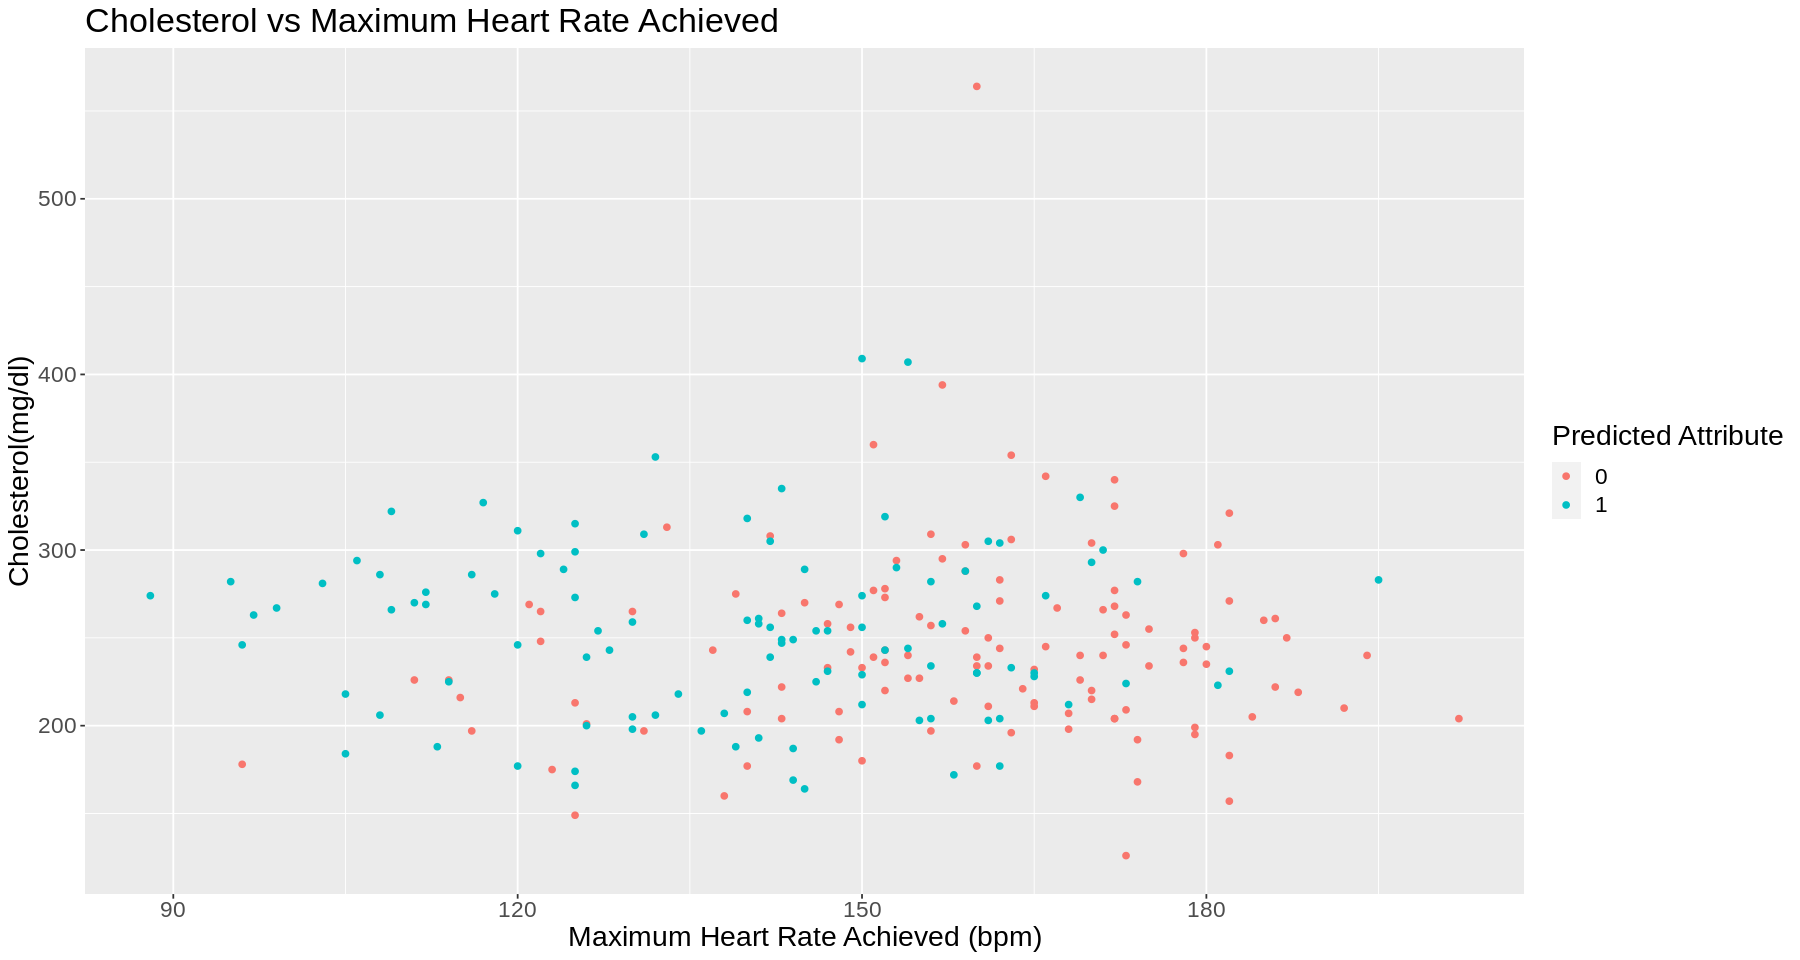

In [8]:
options(repr.plot.width = 15, repr.plot.height = 8) 

chol_v_hr_plot <- data_train |>
ggplot(aes(x = thalach, y = chol, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Maximum Heart Rate Achieved (bpm)", y = "Cholesterol(mg/dl)", colour = "Predicted Attribute") +
ggtitle("Cholesterol vs Maximum Heart Rate Achieved") +
theme(text=element_text(size=17))

chol_v_hr_plot

From the scatterplot, there does not seem to be any relationship between the two variables, Cholesterol and Maximum Heart Rate Achieved. However, we can observe that the most of the red points lie between a heart rate of 150-200 bpm and the most of the blue points lie between 100-150 bpm. So, people without heart disease seem to have a higher heart rate than the people with heart disease (on average).

### Methods:
With this model, we are trying to predict if the person has heart disease or not. This is a categorical variable and it can have only two possible values: 0 (if the person does not have heart disease) and 1 (if the person has heart disease). Therefore, we are using classification to predict the outcome. If we were predicting a numerical value, regression would have been the better choice.We will be using cross-validation to pick the best value of K.

According to our summary table above, the columns `chol` and `thalach` have a  larger difference in mean values for people with and without the disease. This could help the model differentiate better between the two outcomes, rather than including columns that have similar values for both cases. This is why we are choosing them as our predictors.

To visualize the results, we will use a bar graph to see how many of the observations were predicted accurately and how many were not. 

### Expected outcomes and significance:
We expect our model to be reasonably accurate in predicting whether a person has heart disease or not. We would also hopefully be able to observe the range of values for a predictor where our model works well and the range where it does not.

Impact: Once we find out the range where the model works or does not work, we will be able to judge if the model will be reliable or not when we try to classify a new observation. 

Future questions:
- How do we prevent heart disease based on our predictions?
- Can we also classify different types of heart disease?

